# Federated Learning Project
This notebook demonstrates how to set up and compare Federated Learning (FL) with Centralized Learning (CL) using the CIFAR-100 dataset and the modified version of the LeNet-5 model taken from [Hsu et al., Federated Visual Classification with Real-World Data Distribution, ECCV 2020].

## 1. Setup
We start by importing necessary libraries and setting global constants for the experiments.

In [1]:
import sys
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from models.model import LeNet5 #import the model
import numpy as np
sys.path.append('../data/cifar100/')
from cifar100_loader import CIFAR100DataLoader
from Server import Server
from utils.federated_utils import plot_metrics,test, plot_client_selection,save_data,load_data

# Constants

In [2]:
# Constants for FL training
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

NUM_CLIENTS = 100  # Total number of clients in the federation
FRACTION_CLIENTS = 0.1  # Fraction of clients selected per round (C)
LOCAL_STEPS = 4  # Number of local steps (J)
GLOBAL_ROUNDS = 2000  # Total number of communication rounds

BATCH_SIZE = 64  # Batch size for local training
MOMENTUM = 0.9  # Momentum for SGD optimizer
CHECKPOINT_DIR = './checkpoints/'
LOG_FREQUENCY = 10  # Frequency of logging training progress

cuda


## 2. Data Loading
We load the CIFAR-100 dataset and split it into training, validation, and test sets. This is done using the `data_loader.py` module.

In [5]:
#10% of the dataset kept for validation
data_loader = CIFAR100DataLoader(batch_size=BATCH_SIZE, validation_split=0.1, download=True, num_workers=4, pin_memory=True)
trainloader, validloader, testloader = data_loader.train_loader, data_loader.val_loader, data_loader.test_loader

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## 3. Federated Training
We simulate federated learning by splitting the dataset into shards and training with selected clients in each round.

### Initialize Model & Loss

In [3]:
global_model = LeNet5()
criterion = nn.NLLLoss()# our loss function for classification tasks on CIFAR-100

# Hyperparameters tuning
J=4, idd shards, uniform client selection, rounds = 100

In [ ]:
""" 
Hyperparameter tuning for the learning rate and weight decay
J=4, idd shards, uniform client selection, rounds = 100
"""
# Generate 3 values for the learning rate (lr) between 1e-3 and 1e-1 in log-uniform
lr_values = np.logspace(-3, -1, num=3)

# Generate 4 values for the weight decay (lr) between 1e-4 and 1e-1 in log-uniform
wd_values = np.logspace(-4, -1, num=4)

print("Learning Rate Values (log-uniform):", lr_values)
print("Weight Decay Values (log-uniform):", wd_values)

rounds = 100 #fewer communication rounds for hyperparameter tuning
best_val_accuracy = 0
best_setting = None
for lr in lr_values:
    for wd in wd_values:
        print(f"Learning rate: {lr}, Weight decay: {wd}")
        global_model = LeNet5() 
        server = Server(global_model, DEVICE, CHECKPOINT_DIR)                                                                   
        global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=100, rounds=rounds, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, C=FRACTION_CLIENTS, local_steps=LOCAL_STEPS)
        plot_metrics(train_accuracies, train_losses,val_accuracies, val_losses, f"FederatedBaselineTuning_lr_{lr}_wd_{wd}.png")
        print(f"Validation accuracy: {val_accuracies[-1]} with lr: {lr} and wd: {wd}")
        max_val_accuracy = max(val_accuracies)
        if max_val_accuracy > best_val_accuracy:
            best_val_accuracy = max_val_accuracy
            best_setting = (lr,wd)
print(f"Best setting: {best_setting} with validation accuracy: {best_val_accuracy}")

# Training and testing

In [ ]:
""" 
Training and testing with J=4, 2000 communication rounds
"""
lr = 0.1
wd = 0.001
global_model = LeNet5() 
server = Server(global_model, DEVICE, CHECKPOINT_DIR)                                                                   
global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=100, rounds=GLOBAL_ROUNDS, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, C=FRACTION_CLIENTS, local_steps=LOCAL_STEPS)
test_accuracy = test(global_model, testloader)
print(f"Test accuracy: {test_accuracy}")
#If needed for future plots or analysis, no need to train again
save_data(global_model, val_accuracies, val_losses, train_accuracies, train_losses,client_selection_count, "FederatedBaseline.pth")

# Evaluate the effect of client participation
We implemented a skewed client sampling: each client has a different probability of being selected at each round, and can be used to simulate settings in which some clients are more “active” than others. Client selection values are sampled according to a Dirichlet distribution parameterized by an hyperparameter ɣ.
Let's test what happens with different values of gamma:  


**gamma = 0.05** <-- Represents extreme heterogeneity. A small number of clients will dominate the selection process, being chosen almost exclusively, while most clients will rarely participate.  


**gamma = 0.5** <-- Introduces moderate heterogeneity. Some clients have higher selection probabilities than others, but the imbalance is not extreme.  


**gamma = 1**   <-- A standard choice for the Dirichlet distribution. This provides a relatively balanced selection with mild heterogeneity.  


**gamma = 5**   <-- Simulates near-uniform participation, where all clients have almost equal probabilities of being selected.  



In [4]:
# Gamma values to be tested
gamma_values = [0.05, 0.5, 1.0, 5.0]

# Hyperparameter tuning settings
lr_values = np.logspace(-3, -1, num=3)  # Learning rate between 1e-3 and 1e-1 (log-uniform)
wd_values = np.logspace(-4, -1, num=4)  # Weight decay between 1e-4 and 1e-1 (log-uniform)
rounds = 100  # Fewer communication rounds for hyperparameter tuning

# Best results for each gamma
best_settings = {}

# Cycle through the gamma values
for gamma in gamma_values:
    print(f"\n=== Hyperparameter Tuning for Gamma: {gamma} ===\n")
    best_val_accuracy = 0
    best_setting = None
    
    for lr in lr_values:
        for wd in wd_values:
            print(f"Learning rate: {lr}, Weight decay: {wd}")
            
            # Initialize the model and server
            global_model = LeNet5() 
            server = Server(global_model, DEVICE, CHECKPOINT_DIR)
            
            # Federated training with the current hyperparameters
            global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(
                criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=100, 
                rounds=rounds, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, 
                C=FRACTION_CLIENTS, local_steps=LOCAL_STEPS, log_freq=10, detailed_print=False, gamma=gamma
            )
            
            # Plot results (only the best ones are kept at the end)
            plot_metrics(train_accuracies, train_losses, val_accuracies, val_losses, 
                         f"FederatedGamma{gamma}Tuning_lr_{lr}_wd_{wd}.png")
            
            # Calcola la migliore accuratezza su validazione
            max_val_accuracy = max(val_accuracies)
            print(f"Validation accuracy: {max_val_accuracy} with lr: {lr} and wd: {wd}")
            
            if max_val_accuracy > best_val_accuracy:
                best_val_accuracy = max_val_accuracy
                best_setting = (lr, wd)
    
    # Trace best setting for the current gamma
    best_settings[gamma] = {
        'best_lr': best_setting[0],
        'best_wd': best_setting[1],
        'val_accuracy': best_val_accuracy
    }
    print(f"Best setting for Gamma {gamma}: {best_setting} with validation accuracy: {best_val_accuracy}\n")

    
    print(f"\n=== Final Training for Gamma: {gamma} ===\n")
    lr, wd = best_setting
    global_model = LeNet5() 
    server = Server(global_model, DEVICE, CHECKPOINT_DIR)
    
    global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(
        criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=100, 
        rounds=GLOBAL_ROUNDS, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, 
        C=FRACTION_CLIENTS, local_steps=LOCAL_STEPS, log_freq=10, detailed_print=False, gamma=gamma
    )
    
    # Final test
    test_accuracy = test(global_model, testloader)
    print(f"Test accuracy for Gamma {gamma}: {test_accuracy}")
    
    # Save the model and plots
    plot_metrics(train_accuracies, train_losses, val_accuracies, val_losses, 
                 f"FederatedGamma{gamma}_lr_{lr}_wd_{wd}.png")
    plot_client_selection(client_selection_count, f"ClientSelectionGamma{gamma}_lr_{lr}_wd_{wd}.png")
    save_data(global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count, 
              f"FederatedGamma{gamma}.pth")


=== Hyperparameter Tuning for Gamma: 0.05 ===

Learning rate: 0.001, Weight decay: 0.0001



KeyboardInterrupt



# Comparison

c:\Users\Stefano\OneDrive\Desktop\AML_FederatedLearning\cifar100\utils\federated_utils.py:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  save_dict = torch.load(file_path

Data loaded successfully from ./trained_models/FederatedBaseline.pth
Data loaded successfully from ./trained_models/FederatedGamma005.pth
Data loaded successfully from ./trained_models/FederatedGamma05.pth
Data loaded successfully from ./trained_models/FederatedGamma1.pth
Data loaded successfully from ./trained_models/FederatedGamma5.pth


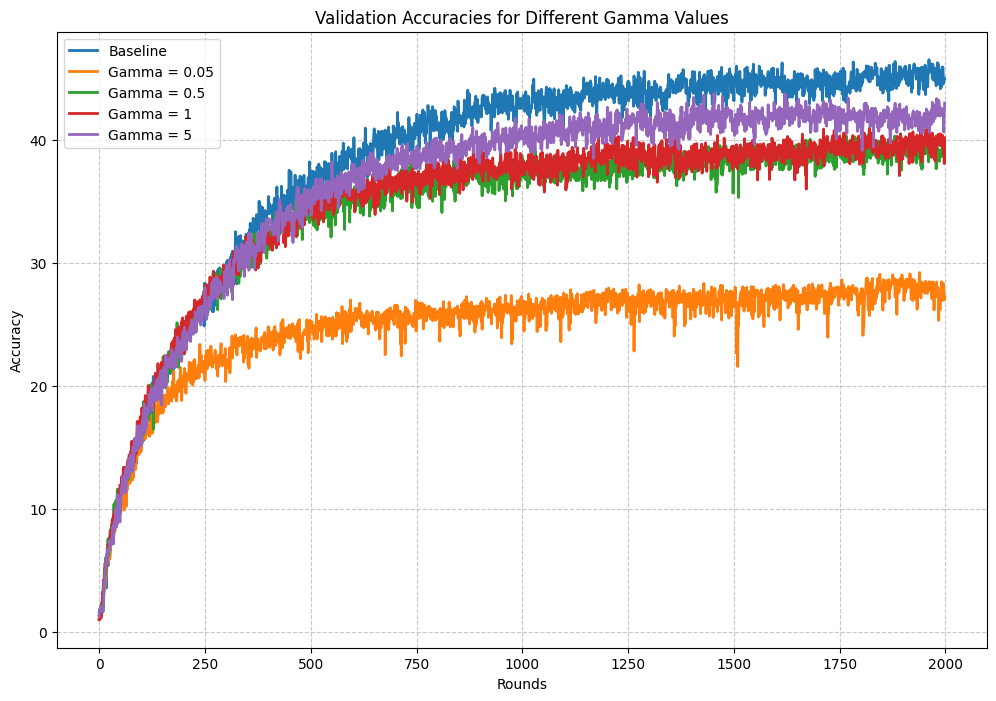

In [5]:
""" 
File to be loaded: 
FederatedBaseline.pth
FederatedGamma005.pth
FederatedGamma05.pth
FederatedGamma5.pth
FederatedGamma1.pth
"""
mm = LeNet5() #Don't care about the model, pass always the same
_, val_accuracies_baseline, _,_,_,_ = load_data(mm,'FederatedBaseline.pth')
val_accuracies_baseline = [val_accuracies_baseline[i]*100 for i in range(len(val_accuracies_baseline))] #They were on a different scale
_, val_accuracies_gamma005, _,_,_,_ = load_data(mm,'FederatedGamma005.pth')
_, val_accuracies_gamma05, _,_,_,_ = load_data(mm,'FederatedGamma05.pth')
_, val_accuracies_gamma1, _,_,_,_ = load_data(mm,'FederatedGamma1.pth')
_, val_accuracies_gamma5, _,_,_,_ = load_data(mm,'FederatedGamma5.pth')


def plot_accuracies_with_menu():
    """
    Plots all validation accuracies for different gamma values on the same graph.
    """
    # Accuracy values for all models
    accuracies = {
        'Baseline': val_accuracies_baseline,
        'Gamma = 0.05': val_accuracies_gamma005,
        'Gamma = 0.5': val_accuracies_gamma05,
        'Gamma = 1': val_accuracies_gamma1,
        'Gamma = 5': val_accuracies_gamma5
    }

    plt.figure(figsize=(12, 8))
    for label, accuracy in accuracies.items():
        plt.plot(accuracy, label=label, linewidth=2) 

    plt.title("Validation Accuracies for Different Gamma Values")
    plt.xlabel("Rounds")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()


plot_accuracies_with_menu()

# Tests with J = 8 and J = 16
Communication rounds accordingly reduced to 1000 and 500 respectively

# Hyperparameters tuning

In [ ]:
""" 
Hyperparameter tuning with J=8, 50 communication rounds
"""
# Generate 3 values for the learning rate (lr) between 1e-3 and 1e-1 in log-uniform
lr_values = np.logspace(-3, -1, num=3)

# Generate 4 values for the weight decay (lr) between 1e-4 and 1e-1 in log-uniform
wd_values = np.logspace(-4, -1, num=4)

print("Learning Rate Values (log-uniform):", lr_values)
print("Weight Decay Values (log-uniform):", wd_values)

rounds = 50 #fewer communication rounds for hyperparameter tuning
best_val_accuracy = 0
best_setting = None
for lr in lr_values:
    for wd in wd_values:
        print(f"Learning rate: {lr}, Weight decay: {wd}")
        global_model = LeNet5() 
        server = Server(global_model, DEVICE, CHECKPOINT_DIR)                                                                   
        global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=100, rounds=rounds, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, C=FRACTION_CLIENTS, local_steps=8)
        plot_metrics(train_accuracies, train_losses,val_accuracies, val_losses, f"FederatedTuningJequalto8_lr_{lr}_wd_{wd}.png")
        print(f"Validation accuracy: {val_accuracies[-1]} with lr: {lr} and wd: {wd}")
        max_val_accuracy = max(val_accuracies)
        if max_val_accuracy > best_val_accuracy:
            best_val_accuracy = max_val_accuracy
            best_setting = (lr,wd)
print(f"Best setting: {best_setting} with validation accuracy: {best_val_accuracy}")

In [ ]:
""" 
Hyperparameter tuning with J=16, 25 communication rounds
"""
# Generate 3 values for the learning rate (lr) between 1e-3 and 1e-1 in log-uniform
lr_values = np.logspace(-3, -1, num=3)

# Generate 4 values for the weight decay (lr) between 1e-4 and 1e-1 in log-uniform
wd_values = np.logspace(-4, -1, num=4)

print("Learning Rate Values (log-uniform):", lr_values)
print("Weight Decay Values (log-uniform):", wd_values)

rounds = 25 #fewer communication rounds for hyperparameter tuning
best_val_accuracy = 0
best_setting = None
for lr in lr_values:
    for wd in wd_values:
        print(f"Learning rate: {lr}, Weight decay: {wd}")
        global_model = LeNet5() 
        server = Server(global_model, DEVICE, CHECKPOINT_DIR)                                                                   
        global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=100, rounds=rounds, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, C=FRACTION_CLIENTS, local_steps=16)
        plot_metrics(train_accuracies, train_losses,val_accuracies, val_losses, f"FederatedTuningJequalto16_lr_{lr}_wd_{wd}.png")
        print(f"Validation accuracy: {val_accuracies[-1]} with lr: {lr} and wd: {wd}")
        max_val_accuracy = max(val_accuracies)
        if max_val_accuracy > best_val_accuracy:
            best_val_accuracy = max_val_accuracy
            best_setting = (lr,wd)
print(f"Best setting: {best_setting} with validation accuracy: {best_val_accuracy}")

# Training and testing

In [ ]:
""" 
8 local steps, 1000 rounds
"""
#lr and wd to be defined based on the hyperparameter tuning
#lr = 0.1
#wd = 0.001
global_model = LeNet5() 
server = Server(global_model, DEVICE, CHECKPOINT_DIR)                                                                   
global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=100, rounds=1000, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, C=FRACTION_CLIENTS, local_steps=8)
test_accuracy = test(global_model, testloader)
print(f"Test accuracy: {test_accuracy}")
#If needed for future plots or analysis, no need to train again
save_data(global_model, val_accuracies, val_losses, train_accuracies, train_losses,client_selection_count, "FederatedJequalto8.pth")

In [ ]:
"""
16 local steps, 500 rounds
"""
#lr and wd to be defined based on the hyperparameter tuning
#lr = 0.1
#wd = 0.001
global_model = LeNet5() 
server = Server(global_model, DEVICE, CHECKPOINT_DIR)                                                                   
global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=100, rounds=500, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, C=FRACTION_CLIENTS, local_steps=16)
test_accuracy = test(global_model, testloader)
print(f"Test accuracy: {test_accuracy}")
#If needed for future plots or analysis, no need to train again
save_data(global_model, val_accuracies, val_losses, train_accuracies, train_losses,client_selection_count, "FederatedJequalto16.pth")

# Simulate heterogeneous distributions
#### (15 Exeperiments)
Fix K=100 and C=0.1, and simulate several non-iid shardings of the training set of CIFAR-100, by fixing the number of different labels clients have (Nc={1,5,10,50}). Then test the performance of FedAvg, comparing with the iid sharding, varying the number of local steps J={4,8,16}. 

### Hyperparameter Tuning

In [ ]:
#Hyperparameters tuning function
def hyperparameters_tuning(num_classes, local_steps, rounds):
    print(f"Hyperparameter tuning for num_classes={num_classes}, local_steps={local_steps}")
    lr_values = np.logspace(-3, -1, num=3)
    wd_values = np.logspace(-4, -1, num=4)
    best_val_accuracy = 0
    best_setting = None
    for lr in lr_values:
        for wd in wd_values:
            print(f"Learning rate: {lr}, Weight decay: {wd}")
            global_model = LeNet5()
            server = Server(global_model, DEVICE, CHECKPOINT_DIR)
            global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(criterion, trainloader, validloader, num_clients=NUM_CLIENTS, num_classes=num_classes, rounds=rounds, lr=lr, momentum=MOMENTUM, batchsize=BATCH_SIZE, wd=wd, C=FRACTION_CLIENTS, local_steps=local_steps,log_freq=100, detailed_print=False,gamma=None)
            plot_metrics(train_accuracies, train_losses,val_accuracies, val_losses, f"FederatedTuning_Nc_{num_classes}_J_{local_steps}_lr_{lr}_wd_{wd}.png")
            print(f"Validation accuracy: {val_accuracies[-1]} with lr: {lr} and wd: {wd}")
            max_val_accuracy = max(val_accuracies)
            if max_val_accuracy > best_val_accuracy:
                best_val_accuracy = max_val_accuracy
                best_setting = (lr,wd)
    print(f"Best setting: {best_setting} with validation accuracy: {best_val_accuracy}")
    return best_setting

### Experiments Loop

In [ ]:
# Constants
LOCAL_STEPS_VALUES = [4, 8, 16]  # Values for J (number of local steps)
NUM_CLASSES_VALUES = [1, 5, 10, 50]  # Number of classes per client for Non-IID
NUM_RUNDS = {4: 2000, 8: 1000, 16:500}
IID_CLASSES = 100  # Full IID distribution

# Function to perform the training and testing for a given configuration
def run_experiment(num_classes, local_steps, plot_suffix):
    print(f"Running experiment: num_classes={num_classes}, local_steps={local_steps}")
    global_model = LeNet5()
    server = Server(global_model, DEVICE, CHECKPOINT_DIR)

    tuning_rounds = int(NUM_RUNDS[local_steps]/20)
    best_lr, best_wd = hyperparameters_tuning(num_classes = num_classes, local_steps=local_steps, rounds=tuning_rounds)

    global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count = server.train_federated(
        criterion, trainloader, validloader, 
        num_clients=NUM_CLIENTS, num_classes=num_classes, 
        rounds=NUM_RUNDS[local_steps], lr=best_lr, momentum=MOMENTUM, 
        batchsize=BATCH_SIZE, wd=best_wd, C=FRACTION_CLIENTS, 
        local_steps=local_steps, log_freq=100, 
        detailed_print=False, gamma=None  # No skewed sampling for this experiment
    )

    # Testing and plotting
    test_accuracy = test(global_model, testloader)
    plot_metrics(train_accuracies, train_losses, val_accuracies, val_losses, f"Federated_{plot_suffix}_LR_{best_lr}_WD_{best_wd}.png")
    print(f"Test accuracy for num_classes={num_classes}, local_steps={local_steps}: {test_accuracy}")

    # Save data for future analysis
    save_data(global_model, val_accuracies, val_losses, train_accuracies, train_losses, client_selection_count, f"Federated_{plot_suffix}_LR_{best_lr}_WD_{best_wd}.pth")

# Main experiment loop
#for num_classes in NUM_CLASSES_VALUES + [IID_CLASSES]:  # Include IID setting
 #   for local_steps in LOCAL_STEPS_VALUES:
  #      plot_suffix = f"num_classes_{num_classes}_local_steps_{local_steps}"
    #    run_experiment(num_classes, local_steps, plot_suffix)

#to run iterations manually
num_classes = 100
local_steps = 8
plot_suffix = f"num_classes_{num_classes}_local_steps_{local_steps}"
run_experiment(num_classes, local_steps, plot_suffix)